# Homework 2 - Generalized Hough Transform

## Programming

Find object in an image using a template:  
![title](data/template.jpg)
![title](data/query.jpg)

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import cv2
import utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

def nonMaxSuprression(img, d=5):
    """
    Given an image set all values to 0 that are not
    the maximum in its (2d+1,2d+1)-window

    Parameters
    ----------
    img : ndarray
        an image
    d : int
        for each pixels consider the surrounding (2d+1,2d+1)-window  

    Returns
    -------
    result : ndarray

    """
    rows,cols = img.shape
    result = np.zeros((rows,cols))
    
    # TODO:
    # iterate over pixels
    for i in range(rows):
        for j in range(cols):
            
            low_x = max(0, i - d)
            low_y = max(0, j - d)
            
            upp_x = min(rows, i + d + 1)
            upp_y = min(cols, j + d + 1)
            
            # iterate over (2d+1,2d+1) neighborhood window
            # supress non-maxima to 0
            # store results in new array
            if img[i,j] == np.max(img[low_x:upp_x, low_y:upp_y]):
                result[i,j] = img[i,j]

    return result

def calcBinaryMask(img, thresh = 0.3):
    """
    Compute the gradient of an image and compute a binary mask
    based on the threshold. Corresponds to O^B in the slides.

    Parameters
    ----------
    img : ndarray
        an image
    thresh : float
        A threshold value. The default is 0.3.

    Returns
    -------
    binary : ndarray
        A binary image.

    """

    # TODO:
    
    # -compute gradients
    grad = utils.calcDirectionalGrad(img = img)
    
    # -threshold gradients
    binary_mask = np.absolute(grad) > (thresh * np.amax(np.abs(grad)))
    
    # -return binary mask
    return binary_mask


def correlation(img, template):
    """
    Compute a correlation of gradients between an image and a template.
    
    Note:
    You should use the formula in the slides using the fourier transform.
    Then you are guaranteed to succeed.
    
    However, you can also compute the correlation directly. 
    The resulting image must have high positive values at positions
    with high correlation.

    Parameters
    ----------
    img : ndarray
        a grayscale image
    template : ndarray
        a grayscale image of the template

    Returns
    -------
    ndarray
        an image containing the correlation between image and template gradients.
    """
    
    # TODO:
    
    # -compute gradient of the image
    I_i = utils.calcDirectionalGrad(img = img)
    
    # -compute gradient of the template
    O_i = utils.calcDirectionalGrad(img = template)
    O_i[calcBinaryMask(img = template) == False] = 0
    
    # -copy template gradient into larger frame
    # -normalize template
    T_norm = np.zeros_like(I_i, dtype = 'complex_')
    T_norm[:O_i.shape[0], :O_i. shape[1]] = (O_i / np.absolute(O_i).sum())
    
    # -apply a circular shift so the center of the original template is in the upper left corner
    T_shift = utils.circularShift(img = T_norm, dx = int(template.shape[1] / 2), dy = int(template.shape[0]/2))
    
    # -compute correlation
    corr = np.fft.ifft2(np.fft.fft2(I_i) * np.conjugate(np.fft.fft2(T_shift)))
    
    return corr



def GeneralizedHoughTransform(img, template, angles, scales):
    """
    Compute the generalized hough transform. Given an image and a template.
    
    Parameters
    ----------
    img : ndarray
        A query image
    template : ndarray
        a template image
    angles : list[float]
        A list of angles provided in degrees
    scales : list[float]
        A list of scaling factors

    Returns
    -------
    hough_table : list[(correlation, angle, scaling)]
        The resulting hough table is a list of tuples.
        Each tuple contains the correlation and the corresponding combination
        of angle and scaling factors of the template.
        
        Note the order of these values.
    """
    # TODO:
    
    hough_table = []
    # for every combination of angles and scales
    for angle in angles:
        for scale in scales:
            # -rotate and scale template
            T_ras = utils.rotateAndScale(img = template, angle = angle ,scale = scale)
            # -compute the correlation
            corr = np.absolute(np.real(correlation(img = img, template = T_ras)))
            # -store results with parameters in a list
            hough_table.append((corr, angle, scale))
    
    return hough_table

# Main Program

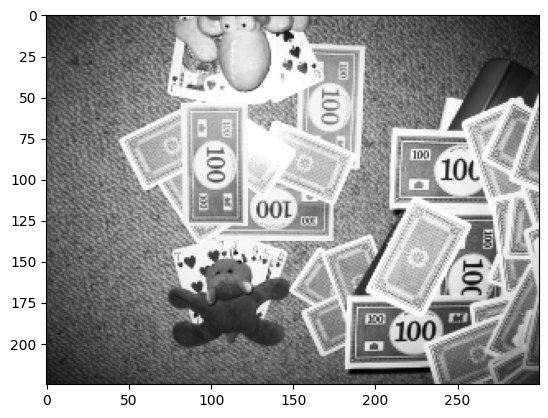

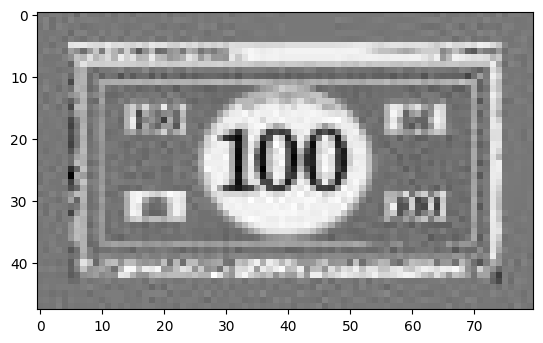

Hough votes


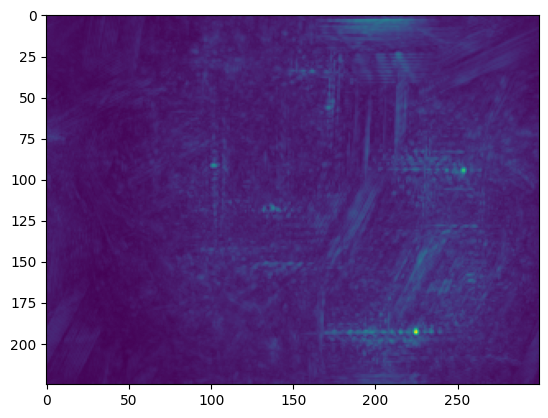

Filtered Hough votes


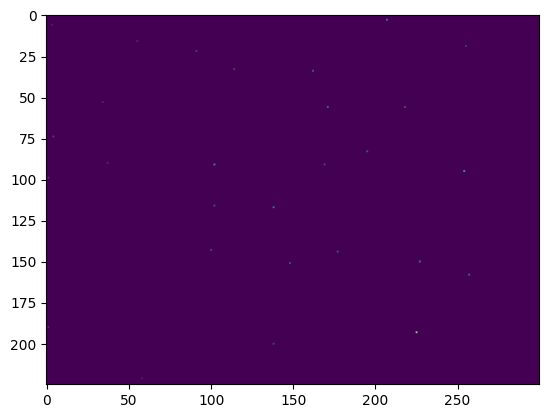

Detected Positions
148 151
162 34
102 91
254 95
171 56
138 117
225 193
207 3
257 158
227 150


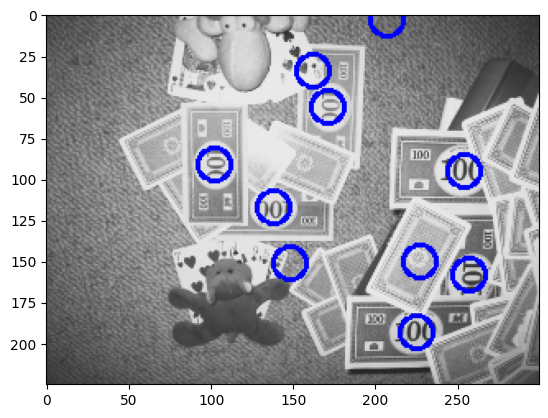

In [2]:
# Load query image and template 
query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)

# Visualize images
utils.show(query)
utils.show(template)

# Create search space and compute GHT
angles = np.linspace(0, 360, 36)
scales = np.linspace(0.9, 1.3, 10)
ght = GeneralizedHoughTransform(query, template, angles, scales)

# extract votes (correlation) and parameters
votes, thetas, s = zip(*ght)

# Visualize votes
print("Hough votes")
votes = np.stack(votes).max(0)
plt.imshow(votes)
plt.show()

# nonMaxSuprression
print("Filtered Hough votes")
votes = nonMaxSuprression(votes, 20)
plt.imshow(votes)
plt.show()

# Visualize n best matches
n = 10
coords = zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape))
vis = np.stack(3*[query],2)
print("Detected Positions")
for y,x in coords:
    print(x,y)
    vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
utils.show(vis)


# Test your implementation

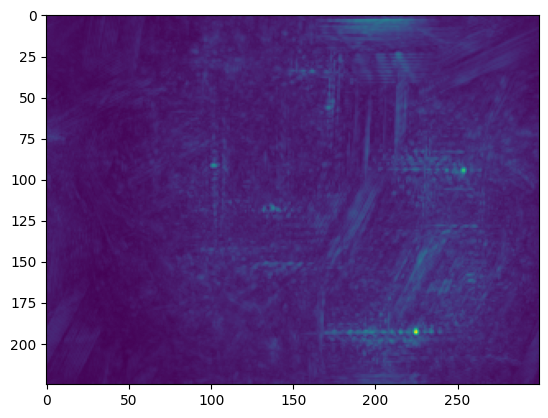

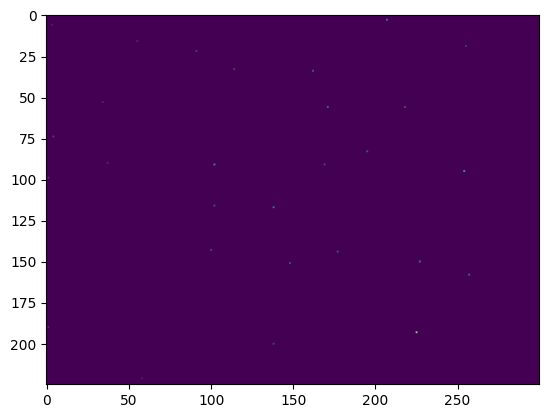

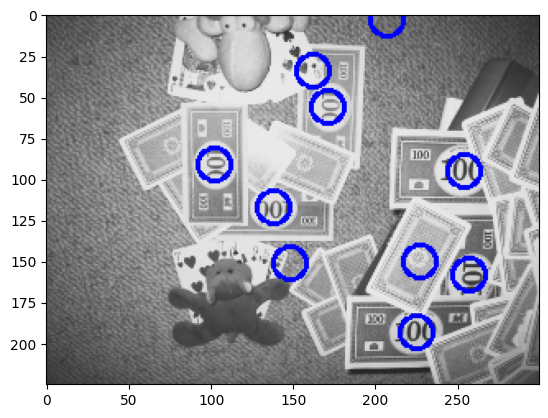

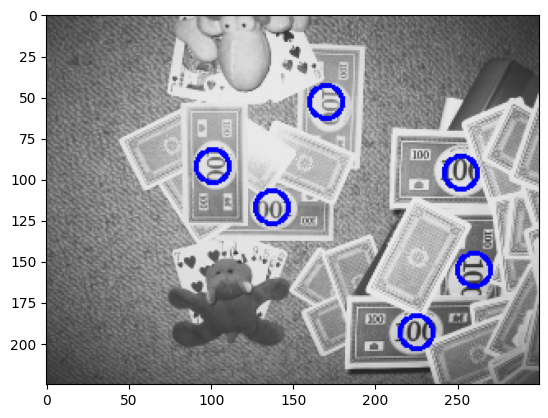

{"scores": {"Correct_Detections": 6}}


In [3]:
import utils
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


def testGHT():
    # Load Images
    query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
    template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)
    
    # GHT with search space
    angles = np.linspace(0, 360, 36)
    scales = np.linspace(0.9, 1.3, 10)
    ght = GeneralizedHoughTransform(query, template, angles, scales)
    
    # Visualize GHT votes
    votes, thetas, s = zip(*ght)
    votes = np.stack(votes).max(0)
    plt.imshow(votes)
    plt.show()

    # Visualize filtered points
    votes = nonMaxSuprression(votes, 20)
    plt.imshow(votes)
    plt.show()

    # Extract n points wiht highest voting score
    n = 10
    coords = list(zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape)))
    vis = np.stack(3*[query],2)
    for y,x in coords:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)

    # Compare with ground-truth centroids
    f = open("centroids.txt", "r")
    centroids = f.read()
    f.close()
    centroids = centroids.split("\n")[:-1]
    centroids = [centroid.split() for centroid in centroids]
    centroids = np.array([[int(centroid[0]),int(centroid[1])] for centroid in centroids])
    
    # Visualize centroids
    vis = np.stack(3*[query],2)
    for x,y in centroids:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)
    
    # Compute Distances and apply threshold
    coords = np.array(coords)[:,::-1]
    d = euclidean_distances(centroids, coords).min(1)
    correct_detections = np.count_nonzero((d<10))
    score = { "scores": {"Correct_Detections": correct_detections }}
    
    print(json.dumps(score))

testGHT()